In [1]:
# matplotlib and it settings
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import torchvision.models as models
print(f"device: {device}")
import torch
import os
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
import pydicom
import re
import time
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import random
import zipfile
import pandas as pd
import io
import h5py
import torch.nn as nn
from tqdm import tqdm
import shutil
from time import sleep

device: cpu


In [2]:
scan_types = ['t2', 'flair', 't1', 't1ce' ]
scan_types = ['t1ce']
data_dir = "./data_1.4_has_tumor_filtered"
data_sourcedir = "./data_1.4.2_has_tumor"
version = "1.4.2"

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    """Imshow for Tensor."""
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [4]:
def visualize_model(model, dataloaders, class_names, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [5]:
def buildmodel(scan_type):
    
    # copy the files to the traning dir
    try:
        shutil.rmtree(data_dir)
    except Exception as e:
        print(e)
    # create directories
    os.makedirs(data_dir)
    train = os.path.join(data_dir, "train")
    sleep(1)
    os.makedirs(train)
    train_1 = os.path.join(train, "1")
    os.makedirs(train_1)
    train_0 = os.path.join(train, "0")
    os.makedirs(train_0)
    val = os.path.join(data_dir, "val")
    sleep(1)
    os.makedirs(val)
    val_1 = os.path.join(val, "1")
    os.makedirs(val_1)
    val_0 = os.path.join(val, "0")
    os.makedirs(val_0)
    sleep(1)
    # copy the files 
    for destination in [train_1, train_0, val_0, val_1]:
        source = destination.replace(data_dir, data_sourcedir)
        for filename in os.listdir(source):
            if re.search("_"+scan_type+"_", filename):
                shutil.copy( os.path.join(source, filename), destination)
            

    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=(-10, 10)),
            transforms.ToTensor()
        ]),
        'val': transforms.Compose([
            transforms.ToTensor()
        ]),
    }


    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x])
                      for x in ['train', 'val']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                                 shuffle=True, num_workers=6)
                  for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    
    # Get a batch of training data
    inputs, classes = next(iter(dataloaders['train']))

    # Make a grid from batch
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in classes])
    
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, 2)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, 
                           dataloaders, dataset_sizes,
                       num_epochs=10)

    # save the model
    torch.save(model_ft, f"model_has_tumor_{version}_{scan_type}.pth")
    
    visualize_model(model_ft, dataloaders, class_names)
    

    
    

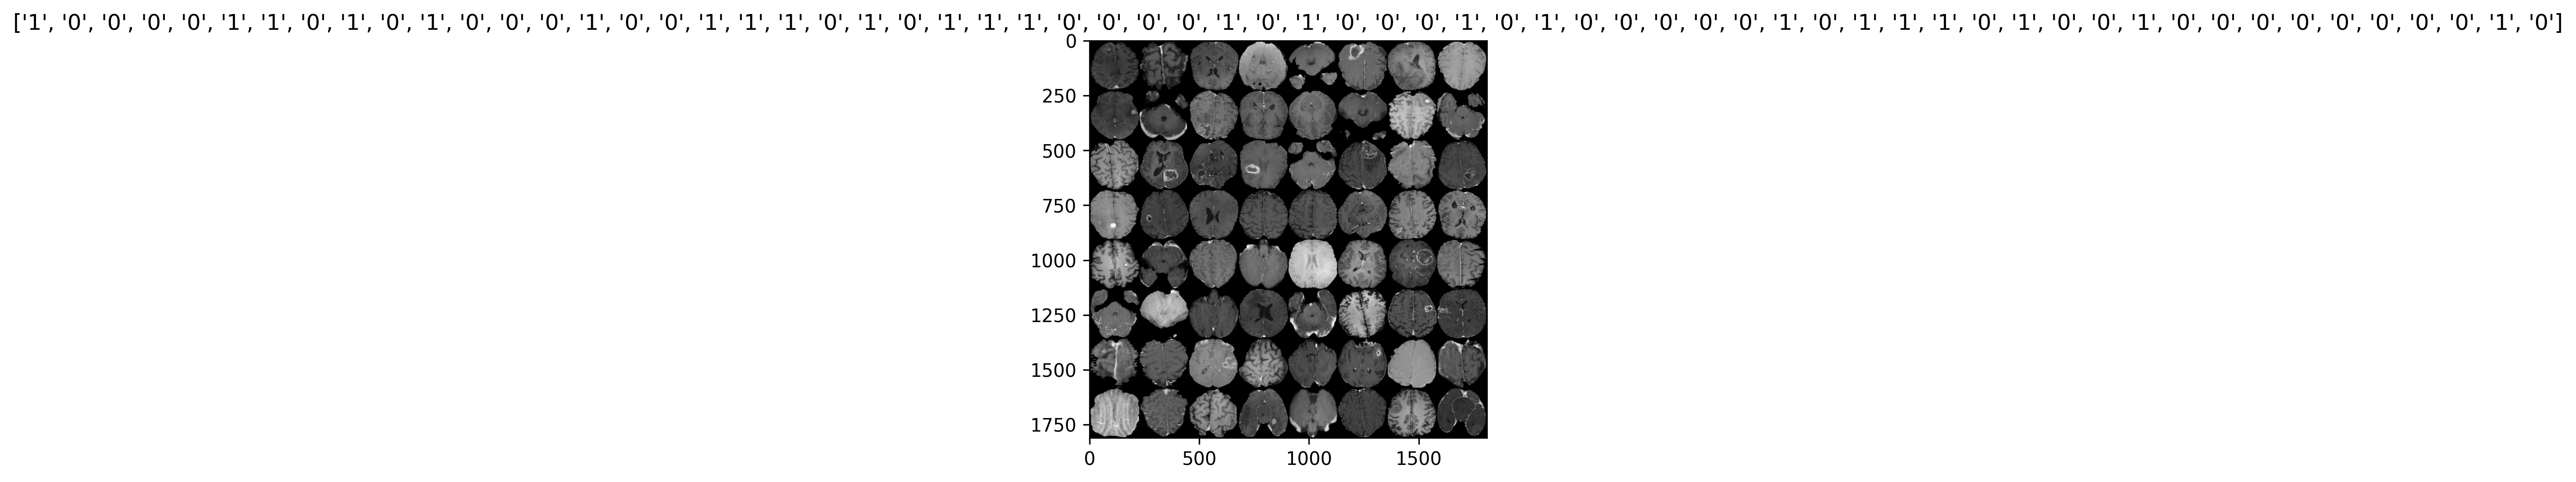

  0%|          | 0/524 [00:00<?, ?it/s]

Epoch 0/9
----------


/opt/homebrew/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  0%|          | 0/132 [00:00<?, ?it/s]

train Loss: 0.3381 Acc: 0.8531


  0%|          | 0/524 [00:00<?, ?it/s]

val Loss: 0.2740 Acc: 0.8887

Epoch 1/9
----------


  0%|          | 0/132 [00:00<?, ?it/s]

train Loss: 0.2412 Acc: 0.9058


  0%|          | 0/524 [00:00<?, ?it/s]

val Loss: 0.2285 Acc: 0.9112

Epoch 2/9
----------


  0%|          | 0/132 [00:00<?, ?it/s]

train Loss: 0.2117 Acc: 0.9165


  0%|          | 0/524 [00:00<?, ?it/s]

val Loss: 0.2096 Acc: 0.9201

Epoch 3/9
----------


  0%|          | 0/132 [00:00<?, ?it/s]

train Loss: 0.1889 Acc: 0.9272


  0%|          | 0/524 [00:00<?, ?it/s]

val Loss: 0.1928 Acc: 0.9272

Epoch 4/9
----------


  0%|          | 0/132 [00:00<?, ?it/s]

train Loss: 0.1713 Acc: 0.9347


  0%|          | 0/524 [00:00<?, ?it/s]

val Loss: 0.1886 Acc: 0.9278

Epoch 5/9
----------


  0%|          | 0/132 [00:00<?, ?it/s]

train Loss: 0.1510 Acc: 0.9413


  0%|          | 0/524 [00:00<?, ?it/s]

val Loss: 0.1623 Acc: 0.9396

Epoch 6/9
----------


  0%|          | 0/132 [00:00<?, ?it/s]

train Loss: 0.1385 Acc: 0.9482


  0%|          | 0/524 [00:00<?, ?it/s]

val Loss: 0.1535 Acc: 0.9423

Epoch 7/9
----------


  0%|          | 0/132 [00:00<?, ?it/s]

train Loss: 0.1161 Acc: 0.9561


  0%|          | 0/524 [00:00<?, ?it/s]

val Loss: 0.1411 Acc: 0.9465

Epoch 8/9
----------


  0%|          | 0/132 [00:00<?, ?it/s]

train Loss: 0.1128 Acc: 0.9590


  0%|          | 0/524 [00:00<?, ?it/s]

val Loss: 0.1382 Acc: 0.9479

Epoch 9/9
----------


  0%|          | 0/132 [00:00<?, ?it/s]

train Loss: 0.1067 Acc: 0.9598


100%|██████████| 132/132 [02:16<00:00,  1.04s/it]

val Loss: 0.1372 Acc: 0.9491

Training complete in 387m 43s
Best val Acc: 0.949096


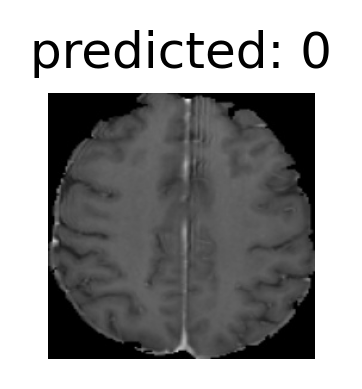

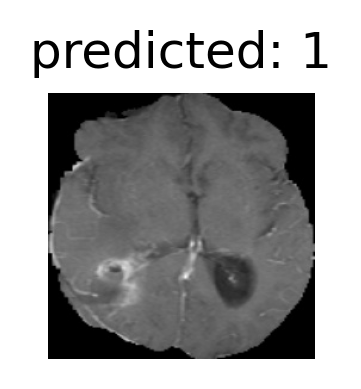

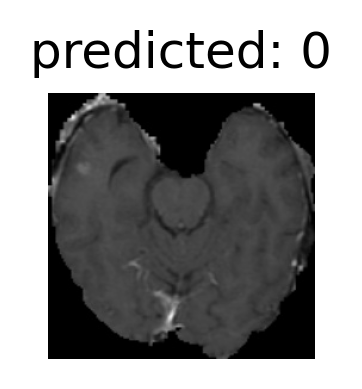

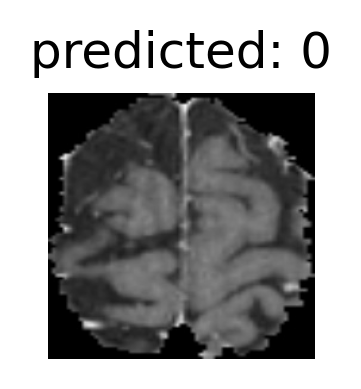

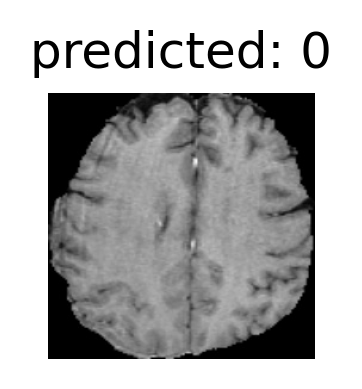

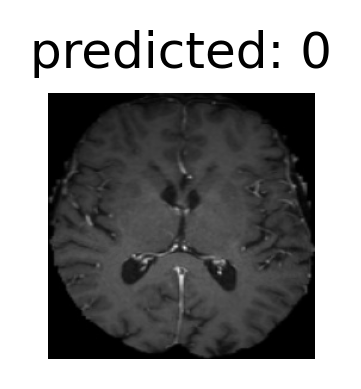

In [6]:
for scan_type in scan_types:
    buildmodel(scan_type)

Source:

https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/